# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import joblib
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Read CSV

In [3]:
data= pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [17]:
data.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [18]:
test.head()

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_1054,440238,6153,218,1377,2017-02-18,PT7M29S,B
1,VID_18629,1040132,8171,340,1047,2016-06-28,PT6M29S,F
2,VID_13967,28534,31,11,1,2014-03-10,PT37M54S,D
3,VID_19442,1316715,2284,250,274,2010-06-05,PT9M55S,G
4,VID_770,1893173,2519,225,116,2016-09-03,PT3M8S,B


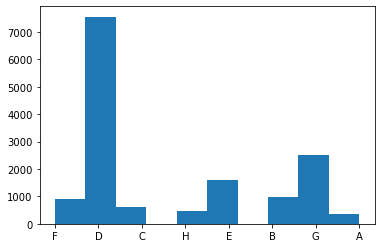

In [19]:
plt.hist(data["category"])
plt.show()

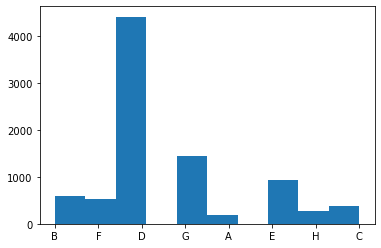

In [20]:
plt.hist(test["category"])
plt.show()

# Pre Processing

In [4]:
categories = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8}

data["category"] = data["category"].map(categories)
test["category"] = test["category"].map(categories)

In [5]:
for e in ["views", "likes", "dislikes", "comment"]:
    data = data[data[e] != "F"]
    for i in range(len(test)):
        if test[e][i]=='F':
            test.loc[i, e] = '0'

for e in ["views", "likes", "dislikes", "comment"]:
    data[e] = pd.to_numeric(data[e])
    if e != 'adview':
        test[e] = pd.to_numeric(test[e])

data = data[data["adview"] < 2000000]
                
data["published"] = LabelEncoder().fit_transform(data["published"])
test["published"] = LabelEncoder().fit_transform(test["published"])

In [6]:
def checki(x):
    y = x[2:]
    h, m, s, mm = "", "", "", ""
    P = ["H", "M", "S"]
    for i in y:
        if i not in P:
            mm += i
        else:
            if i == P[0]:
                h = mm
                mm = ""
            elif i == P[1]:
                m = mm
                mm = ""
            else:
                s = mm
                mm = ""
    if h == "":
        h = "00"
    if m == "":
        m = "00"
    if s == "":
        s = "00"
    bp = h + ":" + m + ":" + s
    return bp

In [7]:
def func_sec(time_str):
    h, m, s = time_str.split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)

In [8]:
data["duration"] = data["duration"].apply(checki).apply(func_sec)
test["duration"] = test["duration"].apply(checki).apply(func_sec)

# Visualize Correlation

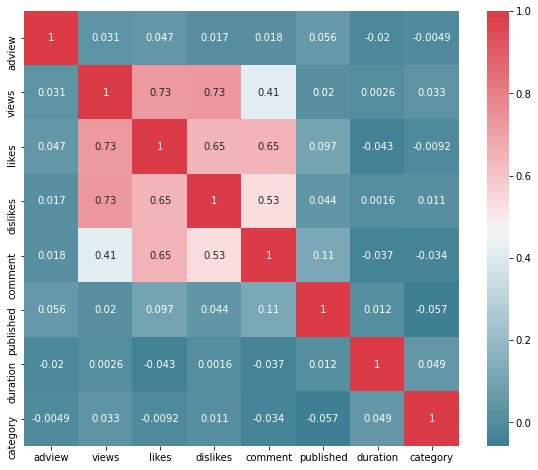

In [9]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
square=True, ax=ax,annot=True)
plt.show()

# Prepare for Input to Model

In [10]:
Y = pd.DataFrame(data.iloc[:, 1].values, columns=["target"])
test_y = pd.DataFrame(test.iloc[:, 0].values, columns=['vidid'])
data = data.drop(["adview", "vidid"], axis=1)
test = test.drop(['vidid'], axis=1)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    data, Y, test_size=0.1, random_state=42
)
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()

In [12]:
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_val = sc_X.transform(X_val)
test = sc_X.transform(test)

# Test on models

In [13]:
def evaluate(X_val, y_val, model):
    y_preds = model.predict(X_val)
    print("RMSE : ", np.sqrt(mean_squared_error(y_val, y_preds)))
    print("R^2 : ", r2_score(y_val, y_preds))
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(y_preds)), y_preds, color='blue', s=1)
    plt.scatter(range(len(y_val)), y_val, color='red', s=1)
    plt.show()

## Linear Regression

Linear Regression
RMSE :  10237.051456261679
R^2 :  -0.02272118759537678


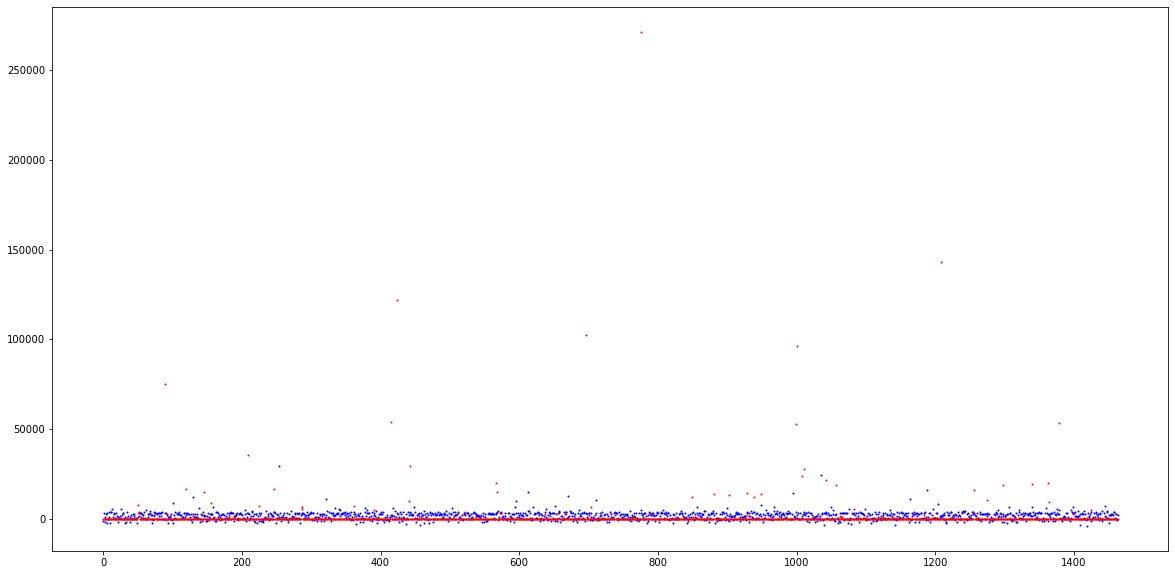

In [31]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
print("Linear Regression")
evaluate(X_val, y_val, linear_regression)

## SVR

SVR
RMSE :  10176.569923886505
R^2 :  -0.010672206520453864


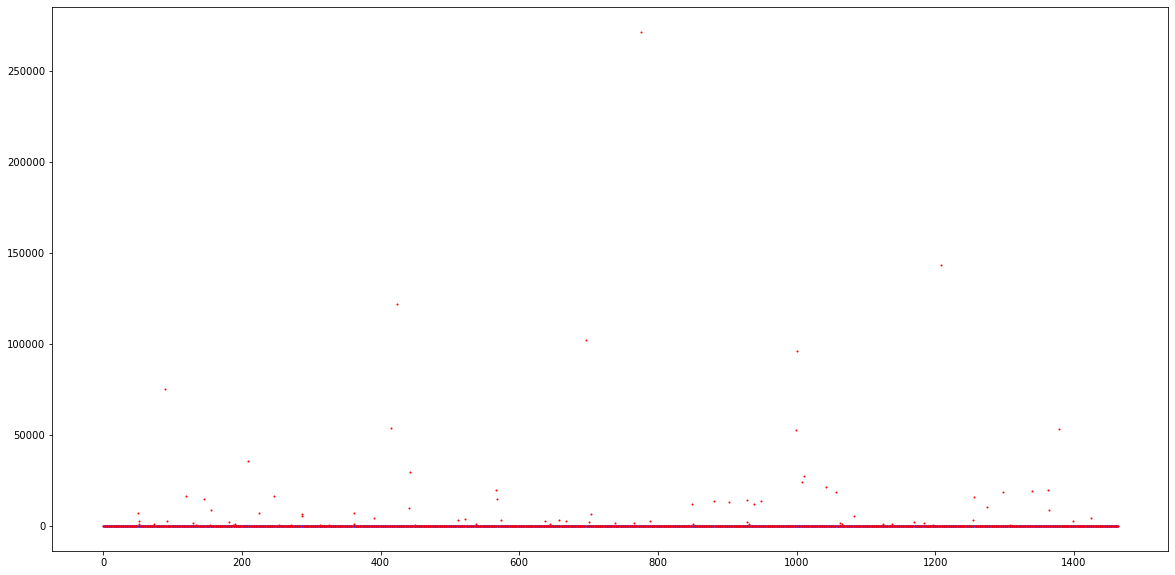

In [16]:
svr_model = SVR()
svr_model.fit(X_train, y_train)
print("SVR")
evaluate(X_val, y_val, svr_model)

## Decision Tree

Decision Tree
RMSE :  15369.809948193219
R^2 :  -1.3053903740898871


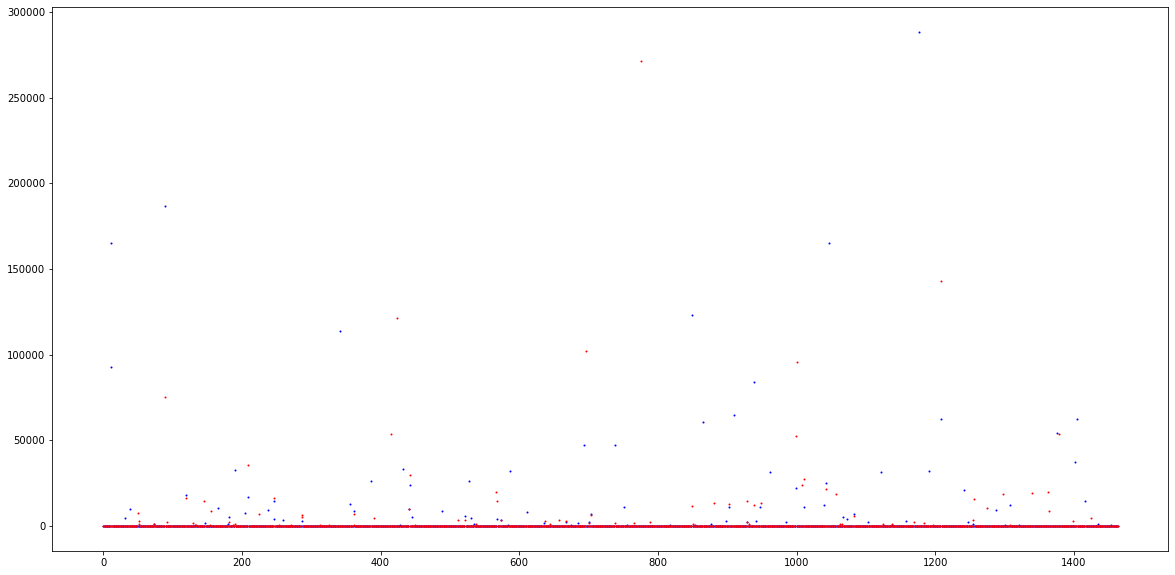

In [14]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
print("Decision Tree")
evaluate(X_val, y_val, dt_model)

## Random Forest

Random Forest
RMSE :  15167.534932754184
R^2 :  -1.245109297823697


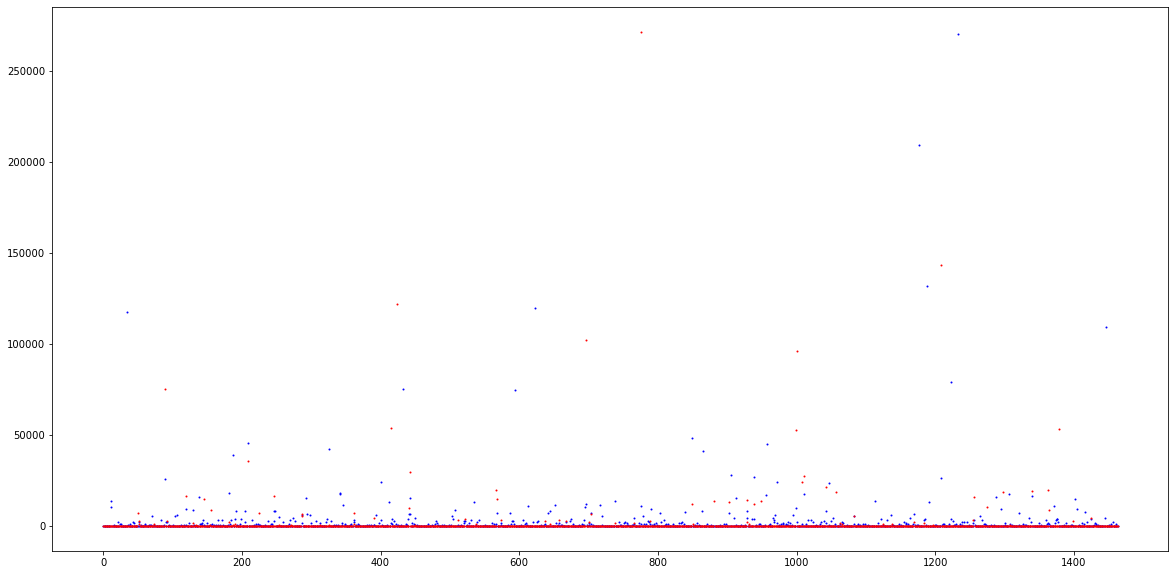

In [40]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
print("Random Forest")
evaluate(X_val, y_val, rf_model)

## Random Forest with HyperParameter tuning

In [41]:
n_estimators = [int(x) for x in np.linspace(50, 300, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 60, num = 3)]
min_samples_split = [5, 10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.2min finished


RMSE :  12213.67971893185
R^2 :  -0.45579604515444694


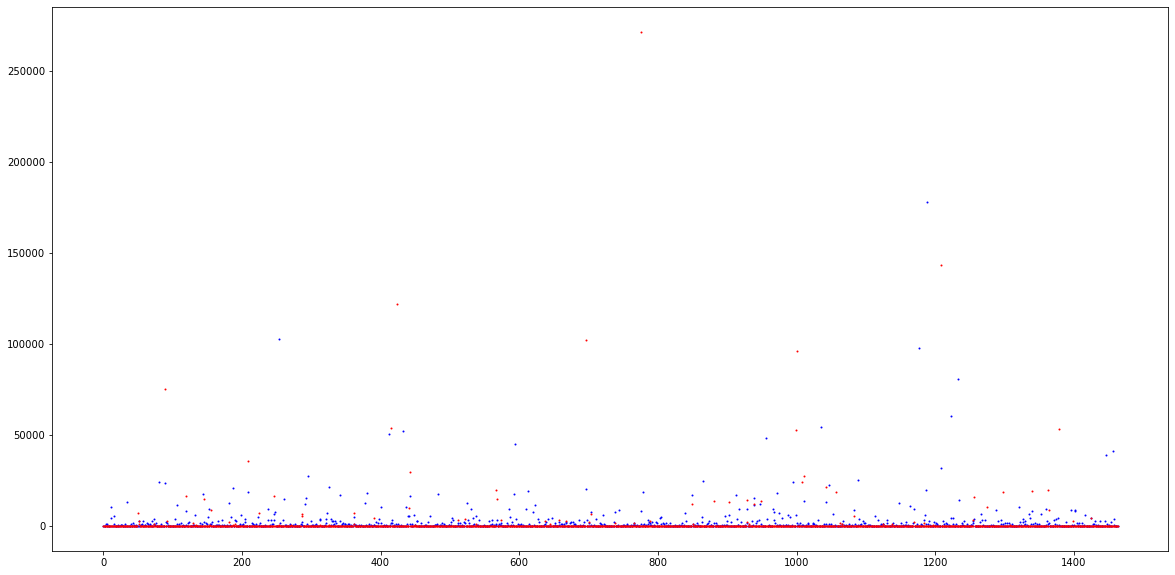

In [42]:
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions = random_grid, n_iter = 10, cv = 10, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_random.fit(X_train, y_train)
evaluate(X_val, y_val, rf_random.best_estimator_)

## Neural Network

In [ ]:
nn_model = keras.models.Sequential([
                keras.layers.Dense(16, input_shape=(7,), activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(16, activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(8, activation='relu'),
                keras.layers.Dense(units=1)
])

In [ ]:
nn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

In [ ]:
nn_model.fit(X_train, y_train, epochs=200, verbose=0)
evaluate(X_val, y_val, nn_model)

# Save Model

In [19]:
joblib.dump(svr_model, "svr_model.pkl")

['svr_model.pkl']

In [ ]:
nn_model.save('nn_model.h5')

# Load Model

In [20]:
model = joblib.load('svr_model.pkl')

In [21]:
preds = model.predict(test)

In [22]:
preds = preds.tolist()
d = {'adview': preds}
pd.DataFrame(d).to_csv('predictions.csv', header=False, index=False)